
# Họ và tên: Lê Trọng Đại Trường
# MSSV: 22521576


In [1]:
import os
import sys
import torch

print(torch.__version__)
print(torch.cuda.is_available())

2.4.0
True


# CS331-BT3

## Import Data

In [2]:
import kagglehub

# Download latest version
ds_path = kagglehub.dataset_download("wenewone/cub2002011")
print("Path to dataset files:", ds_path)

Path to dataset files: /kaggle/input/cub2002011


## Load Data

In [3]:
import pandas as pd

def load_df(path, cols):
    df = pd.read_csv(path, sep=" ", header=None)
    df.columns = cols
    return df

In [4]:
dir = "/kaggle/input/cub2002011/CUB_200_2011/"
df1 = load_df(dir + "images.txt", ["id", "path"])
df2 =  load_df(dir + "bounding_boxes.txt", ["id", "x", "y", "w", "h"])
df3 = load_df(dir + "image_class_labels.txt", ["id", "class"])
df4 = load_df(dir + "train_test_split.txt", ["id", "is_train"])

merged_df = df1.merge(df2, on='id', how='inner')  # Merge df1 and df2
merged_df = merged_df.merge(df3, on='id', how='inner') # Merge with df3
merged_df = merged_df.merge(df4, on='id', how='inner') # Merge with df4
del df1, df2, df3, df4
merged_df.info()
merged_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11788 entries, 0 to 11787
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        11788 non-null  int64  
 1   path      11788 non-null  object 
 2   x         11788 non-null  float64
 3   y         11788 non-null  float64
 4   w         11788 non-null  float64
 5   h         11788 non-null  float64
 6   class     11788 non-null  int64  
 7   is_train  11788 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 736.9+ KB


,id,path,x,y,w,h,class,is_train
0,1,001.Black_footed_Albatross/Black_Footed_Albatr...,60.0,27.0,325.0,304.0,1,0
1,2,001.Black_footed_Albatross/Black_Footed_Albatr...,139.0,30.0,153.0,264.0,1,1
2,3,001.Black_footed_Albatross/Black_Footed_Albatr...,14.0,112.0,388.0,186.0,1,0
3,4,001.Black_footed_Albatross/Black_Footed_Albatr...,112.0,90.0,255.0,242.0,1,1
4,5,001.Black_footed_Albatross/Black_Footed_Albatr...,70.0,50.0,134.0,303.0,1,1


In [7]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms

In [8]:
class MyDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Thay đổi kích thước ảnh về 224x224 pixels
        transforms.ToTensor(),          # Chuyển đổi ảnh PIL hoặc NumPy array thành tensor PyTorch
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],  # Giá trị trung bình cho từng kênh màu (RGB) theo ImageNet
            std=[0.229, 0.224, 0.225]    # Độ lệch chuẩn cho từng kênh màu (RGB) theo ImageNet
        )
    ])
        self.image_dir = "/kaggle/input/cub2002011/CUB_200_2011/images"
        self.num_class = 200

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        image_path = os.path.join(self.image_dir, row['path'])
        
        # Lấy tọa độ và kích thước của bounding box
        x_center = row['x'] + row['w'] / 2
        y_center = row['y'] + row['h'] / 2
        width, height = row['w'], row['h']
        
        # Đọc ảnh và xử lý
        image = Image.open(image_path).convert("RGB")
        img_width, img_height = image.size
        image = self.transform(image)
        
        # Chuẩn hóa bounding box theo kích thước ảnh
        x_center /= img_width
        y_center /= img_height
        width /= img_width
        height /= img_height
        
        # Chuẩn bị nhãn lớp
        cls = row['class'] - 1
        cls_one_hot = torch.nn.functional.one_hot(torch.tensor(cls), num_classes=self.num_class).type(torch.float32)
        
        # Trả về dictionary với dữ liệu đã chuẩn bị
        return {
            "ts": image.type(torch.float32),
            "gt": {
                "box": torch.tensor([x_center, y_center, width, height], dtype=torch.float32),
                "cls": cls_one_hot
            }
        }

# Create an instance of your custom dataset
train_df = merged_df[merged_df['is_train'] == 1].reset_index(drop=True)
valid_df = merged_df[merged_df['is_train'] == 0].reset_index(drop=True)
train_df.head()

,id,path,x,y,w,h,class,is_train
0,2,001.Black_footed_Albatross/Black_Footed_Albatr...,139.0,30.0,153.0,264.0,1,1
1,4,001.Black_footed_Albatross/Black_Footed_Albatr...,112.0,90.0,255.0,242.0,1,1
2,5,001.Black_footed_Albatross/Black_Footed_Albatr...,70.0,50.0,134.0,303.0,1,1
3,7,001.Black_footed_Albatross/Black_Footed_Albatr...,7.0,75.0,420.0,262.0,1,1
4,8,001.Black_footed_Albatross/Black_Footed_Albatr...,78.0,86.0,333.0,158.0,1,1


In [9]:
dataset = MyDataset(train_df)
val_dataset = MyDataset(valid_df)
# Create a DataLoader
BS = 32
dataloader = DataLoader(dataset, batch_size=BS, shuffle=True, num_workers=os.cpu_count(), prefetch_factor=2)
val_dataloader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=os.cpu_count(), prefetch_factor=2)

# Iterate over the DataLoader
for batch in val_dataloader:
    images, targets = batch["ts"], batch["gt"]
    print(images.shape, targets["box"].shape, targets["cls"].shape)
    break

torch.Size([32, 3, 224, 224]) torch.Size([32, 4]) torch.Size([32, 200])


In [10]:
dataset[0]["ts"].dtype 

torch.float32

## Model

### LossFunction

In [11]:
import torch.nn as nn

In [12]:
class LossFunction(nn.Module):
    def __init__(self, cls_weight=5.0, box_weight=0.5, eps=1e-6):
        super().__init__()
        self.cls_weight = cls_weight  # Trọng số cho loss phân loại
        self.box_weight = box_weight  # Trọng số cho loss bounding box
        self.eps = eps  # Epsilon tránh NaN
        self.cls_loss_fn = nn.CrossEntropyLoss() 
        self.box_loss_fn = nn.MSELoss()  

    def forward(self, predictions, targets):

        bbox_preds = predictions["box"]  # (bs, 4)
        class_preds = predictions["cls"]  # (bs, num-prob)
        target_boxes = targets["box"]  # Hộp giới hạn ground truth (bs, 4)
        target_labels = targets["cls"]  # Nhãn phân loại ground truth (bs, num-onehot)
        cls_loss = self.cls_loss_fn(class_preds, target_labels)

        # Nhân bản các tensor để tránh thay đổi trực tiếp trên các tensor gốc
        bbox_preds_sqrt = bbox_preds.clone()
        target_boxes_sqrt = target_boxes.clone()

        # Tính toán loss hộp giới hạn
        box_loss = self.box_loss_fn(bbox_preds_sqrt, target_boxes_sqrt)

        # Kết hợp các loss với trọng số và epsilon để tránh NaN
        total_loss = (self.cls_weight * (cls_loss + self.eps)**2) + (self.box_weight * (box_loss + self.eps))

        # Trả về tổng loss
        return total_loss


### NeuralNetwork

In [17]:
import torchvision 

In [19]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_classes):
        super(NeuralNetwork, self).__init__()
        # Sử dụng mô hình ResNet18 đã được huấn luyện trước để trích xuất đặc trưng
        self.features = torchvision.models.resnet18(pretrained=True)
        
        # Thay thế lớp fully connected cuối cùng bằng một lớp Identity để loại bỏ phần phân loại mặc định
        num_ftrs = self.features.fc.in_features
        self.features.fc = nn.Identity()  

        # Các lớp dự đoán hộp giới hạn (bounding box) và lớp
        self.bbox_head = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 4)  # 4 tọa độ cho bounding box (x, y, w, h)
        )
        
        self.cls_head = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)  # Lớp phân loại đầu ra
        )

        # Hàm tính toán loss
        self.loss_fn = LossFunction()

    def forward(self, x, gts=None):
        x = self.features(x)
        bbox_preds = self.bbox_head(x)
        class_preds = self.cls_head(x)
        outs = {
            "box": bbox_preds,
            "cls": class_preds
        }
        if gts is not None:
            loss = self.loss_fn(outs, gts)
            return {"outs": outs, "loss": loss}
        return {"outs": outs}

### Evaluation

In [14]:
def calculate_iou(box1, box2):

    # Chuyển đổi sang tensor nếu chưa phải tensor
    box1 = torch.as_tensor(box1, dtype=torch.float32)
    box2 = torch.as_tensor(box2, dtype=torch.float32)

    # Tính tọa độ (x1, y1, x2, y2) cho từng bounding box
    box1_x1, box1_y1 = box1[0] - box1[2] / 2, box1[1] - box1[3] / 2
    box1_x2, box1_y2 = box1[0] + box1[2] / 2, box1[1] + box1[3] / 2

    box2_x1, box2_y1 = box2[0] - box2[2] / 2, box2[1] - box2[3] / 2
    box2_x2, box2_y2 = box2[0] + box2[2] / 2, box2[1] + box2[3] / 2

    # Tính diện tích giao nhau (intersection area)
    x1, y1 = max(box1_x1, box2_x1), max(box1_y1, box2_y1)
    x2, y2 = min(box1_x2, box2_x2), min(box1_y2, box2_y2)

    inter_width = max(0, x2 - x1)
    inter_height = max(0, y2 - y1)
    inter_area = inter_width * inter_height

    # Tính diện tích hợp nhất (union area)
    box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
    union_area = box1_area + box2_area - inter_area

    # Tính IoU
    iou = inter_area / union_area
    return iou.item()  # Trả về giá trị IoU dạng scalar của Python


### Test Demo

In [21]:
# Khởi tạo số lượng lớp
num_classes = 200  

# Khởi tạo mô hình NeuralNetwork và chuyển đổi sang kiểu dữ liệu float32
model = NeuralNetwork(num_classes=num_classes).to(dtype=torch.float32)

# Lấy mẫu ảnh và ground truth từ dataset
sample = dataset[0]
image_tensor, gt = sample["ts"], sample["gt"]

# Thêm một chiều batch vào tensor ảnh và ground truth
dummy_image = image_tensor.unsqueeze(0)  
gt = {key: value.unsqueeze(0) for key, value in gt.items()}

# Dự đoán với mô hình mà không tính toán gradient
with torch.no_grad():
    output = model(dummy_image, gt)
    predictions = output["outs"]
    print(predictions)
    print("Loss:", output["loss"])

    # Trích xuất giá trị dự đoán cho bounding box và lớp
    reg_deltas, cls_scores = predictions["box"], predictions["cls"]
    
    # Tính toán và in giá trị IoU cho từng bounding box
    for i in range(len(reg_deltas)):
        iou = calculate_iou(reg_deltas[i], gt["box"][i])
        print("Single IoU:", iou)

# In hình dạng của class scores và regression deltas
print("Class Scores shape:", cls_scores.shape)  
print("Regression Deltas shape:", reg_deltas.shape)  

# In một số giá trị mẫu của class scores và regression deltas
print("Sample Class Scores:", cls_scores)
print("Sample Regression Deltas:", reg_deltas)


{'box': tensor([[-0.0652,  0.0212, -0.0663, -0.1827]]), 'cls': tensor([[-0.4691, -0.0030, -0.1614, -0.0397, -0.0091,  0.2930, -0.2538,  0.2937,
         -0.1602, -0.3722, -0.1346, -0.2008, -0.1717, -0.2530, -0.1595,  0.5149,
          0.2037,  0.2095,  0.1657, -0.1185,  0.0993,  0.1451,  0.1652,  0.1126,
         -0.1182, -0.1253, -0.0771, -0.2692, -0.0227,  0.0607, -0.2728, -0.1477,
          0.1690, -0.0516, -0.0201,  0.3574,  0.2325,  0.2463, -0.2150,  0.1227,
          0.0371, -0.0870, -0.0171,  0.0599, -0.0327, -0.1628,  0.0258, -0.1812,
          0.2278,  0.1131,  0.3483,  0.5199, -0.1547, -0.2492,  0.2542,  0.0916,
         -0.1431,  0.1299,  0.1459,  0.2132,  0.3996, -0.0706,  0.2279,  0.2364,
         -0.3045, -0.0064,  0.3232, -0.0369, -0.1824,  0.0648, -0.0572, -0.1067,
         -0.3293,  0.3704,  0.0305, -0.1415, -0.0336,  0.1102, -0.3102,  0.2163,
          0.1698, -0.0607, -0.0322,  0.0088, -0.4030, -0.2890,  0.2226, -0.0588,
         -0.1228, -0.3064, -0.1394,  0.0503, -

## Training

In [22]:
model.to("cuda")

NeuralNetwork(
  (features): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [23]:
import torch.optim as optim
from torch.utils.data import DataLoader

In [25]:
class BaseModel:
    def __init__(self, model):
        self.model = model
        self.optimizer = optim.Adam(self.model.parameters())
        self.history = {"train_loss": [], "val_iou": []}
        
    def prepare_inputs(self, inputs, dtype, device):
        inputs["ts"] = inputs["ts"].to(device, dtype)
        inputs["gt"]["box"] = inputs["gt"]["box"].to(device, dtype)
        inputs["gt"]["cls"] = inputs["gt"]["cls"].to(device, dtype)
        return inputs

    def train_per_epoch(self, train_loader, dtype, device):
        # Đặt model vào chế độ training
        self.model.train()
        total_loss = 0
        
        # Lặp qua từng batch trong train_loader
        for batch_idx, batch in enumerate(train_loader):
            # Chuẩn bị dữ liệu đầu vào
            inputs = self.prepare_inputs(batch, dtype, device)
            
            # Thực hiện forward pass
            outputs = self.model(inputs["ts"], inputs["gt"])
            loss = outputs["loss"]
            
            # Backward pass và tối ưu hóa
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            # Cộng dồn giá trị loss của từng batch
            total_loss += loss.item()
            
            # Cập nhật tiến trình sau mỗi 50 batch
            if batch_idx % 50 == 0:
                avg_loss = total_loss / (batch_idx + 1)
                print(f"[Batch {batch_idx + 1}] - Loss: Current: {loss.item():.4f}, Avg: {avg_loss:.4f}")
        
        # Tính loss trung bình cho toàn bộ epoch
        avg_loss = total_loss / len(train_loader)
        self.history["train_loss"].append(avg_loss)
        
        # Trả về giá trị loss trung bình
        return avg_loss


    def validate_per_epoch(self, val_loader, dtype, device):
        # Đặt model vào chế độ đánh giá (evaluation mode)
        self.model.eval()
        total_iou = 0
        total_acc = 0
        
        # Không tính toán gradient trong suốt quá trình đánh giá
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_loader):
                # Chuẩn bị dữ liệu đầu vào
                inputs = self.prepare_inputs(batch, dtype, device)
    
                # Forward pass
                gts, outputs = inputs["gt"], self.model(inputs["ts"])["outs"]
                
                # Tính toán IoU trung bình cho batch hiện tại
                iou_sum = sum(
                    calculate_iou(outputs["box"][i], gts["box"][i]) 
                    if outputs["cls"][i].argmax() == gts["cls"][i].argmax() 
                    else calculate_iou(outputs["box"][i], gts["box"][i])
                    for i in range(len(outputs["box"]))
                )
                avg_iou = iou_sum / len(outputs["box"])
    
                # Tính toán độ chính xác (accuracy) cho batch hiện tại
                acc = sum(
                    1.0 if outputs["cls"][i].argmax() == gts["cls"][i].argmax() 
                    else 0.0
                    for i in range(len(outputs["box"]))
                ) / len(outputs["box"])
    
                # Cộng dồn IoU và accuracy cho từng batch
                total_iou += avg_iou
                total_acc += acc
    
                # Cập nhật tiến trình sau mỗi 50 batch
                if batch_idx % 50 == 0:
                    avg_iou_progress = total_iou / (batch_idx + 1)
                    avg_acc_progress = total_acc / (batch_idx + 1)
                    print(f"[Batch {batch_idx + 1}] - IoU: Current: {avg_iou:.4f}, Avg: {avg_iou_progress:.4f} - Acc: {avg_acc_progress:.4f}")
        
        # Tính toán IoU trung bình cho toàn bộ epoch
        avg_iou = total_iou / len(val_loader)
        self.history["val_iou"].append(avg_iou)
        
        # Trả về IoU trung bình
        return avg_iou

    def train(self, train_loader, val_loader, epochs):
        for epoch in range(1, epochs + 1):
            print(f"Epoch {epoch}/{epochs}")
            val_iou = self.validate_per_epoch(val_loader, torch.float32, "cuda")
            print(f"Validation IoU: {val_iou:.4f}")
            
            train_loss = self.train_per_epoch(train_loader, torch.float32, "cuda")
            print(f"Training Loss: {train_loss:.4f}")
            
            



In [26]:
base_model = BaseModel(model)
epochs = 35
base_model.train(dataloader, val_dataloader, epochs)

Epoch 1/35
[Batch 1] - IoU: Current: 0.0000, Avg: 0.0000 - Acc: 0.0000
[Batch 51] - IoU: Current: 0.0000, Avg: 0.0000 - Acc: 0.0067
[Batch 101] - IoU: Current: 0.0000, Avg: 0.0000 - Acc: 0.0037
[Batch 151] - IoU: Current: 0.0000, Avg: 0.0000 - Acc: 0.0058
Validation IoU: 0.0000
[Batch 1] - Loss: Current: 142.3975, Avg: 142.3975
[Batch 51] - Loss: Current: 118.8461, Avg: 135.4725
[Batch 101] - Loss: Current: 88.8822, Avg: 125.2814
[Batch 151] - Loss: Current: 86.1510, Avg: 115.1437
Training Loss: 109.1783
Epoch 2/35
[Batch 1] - IoU: Current: 0.4147, Avg: 0.4147 - Acc: 0.0000
[Batch 51] - IoU: Current: 0.4293, Avg: 0.4842 - Acc: 0.0404
[Batch 101] - IoU: Current: 0.4184, Avg: 0.4919 - Acc: 0.0684
[Batch 151] - IoU: Current: 0.4608, Avg: 0.4934 - Acc: 0.0598
Validation IoU: 0.4944
[Batch 1] - Loss: Current: 81.2199, Avg: 81.2199
[Batch 51] - Loss: Current: 67.4306, Avg: 71.7406
[Batch 101] - Loss: Current: 50.4067, Avg: 66.8739
[Batch 151] - Loss: Current: 47.5021, Avg: 65.3599
Training L

## Plot

In [31]:
import matplotlib.pyplot as plt 

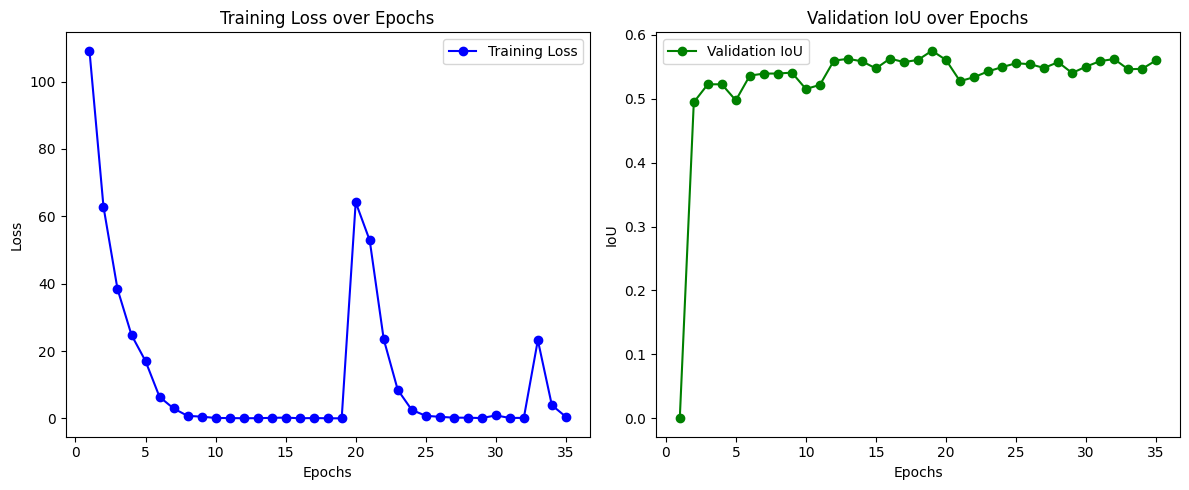

In [32]:
epochs = range(1, len(base_model.history["train_loss"]) + 1)
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(epochs, base_model.history["train_loss"], 'b-o', label='Training Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()

# Plot validation IoU
plt.subplot(1, 2, 2)
plt.plot(epochs, base_model.history["val_iou"], 'g-o', label='Validation IoU')
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.title("Validation IoU over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

In [34]:
base_model.model.eval()
total_iou, total_acc = 0, 0
val_loader = val_dataloader

In [36]:
# Không tính toán gradient trong quá trình đánh giá
with torch.no_grad():
    for batch_idx, batch in enumerate(val_loader):
        # Chuẩn bị dữ liệu đầu vào
        inputs = base_model.prepare_inputs(batch, torch.float32, "cuda")
        
        # Thực hiện forward pass
        gts, predictions = inputs["gt"], base_model.model(inputs["ts"])["outs"]
        
        # Tính toán IoU trung bình cho batch hiện tại
        iou_sum = sum(
            calculate_iou(predictions["box"][i], gts["box"][i]) 
            if predictions["cls"][i].argmax() == gts["cls"][i].argmax() 
            else calculate_iou(predictions["box"][i], gts["box"][i])
            for i in range(len(predictions["box"]))
        )
        avg_iou = iou_sum / len(predictions["box"])

        # Tính toán độ chính xác (accuracy) cho batch hiện tại
        acc = sum(
            1.0 if predictions["cls"][i].argmax() == gts["cls"][i].argmax() 
            else 0.0
            for i in range(len(predictions["box"]))
        ) / len(predictions["box"])

        # Cộng dồn IoU và accuracy cho từng batch
        total_iou += avg_iou
        total_acc += acc

In [37]:
# Tính toán IoU và accuracy trung bình cho toàn bộ tập validation
avg_iou = total_iou / len(val_loader)
avg_acc = total_acc / len(val_loader)

# In ra kết quả IoU và accuracy trung bình
print(f"[With {len(epochs)} epoch] avg-IoU: {avg_iou:.4f} - Acc: {avg_acc:.4f}")

[With 35 epoch] avg-IoU: 1.1177 - Acc: 0.7967


In [38]:
from matplotlib.patches import Rectangle

In [42]:
def Visualization(image, x_center, y_center, width, height, color='r'):
    x_min, y_min = x_center - width / 2, y_center - height / 2
    plt.imshow(image)
    plt.title("Input Image with Bounding Box")
    rect = Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor=color, facecolor='none')
    plt.gca().add_patch(rect)

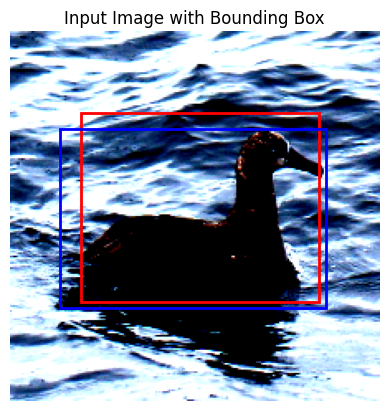

In [43]:
idx = 18
sample = val_dataset[idx]
image_tensor, gt_box, gt_cls = sample["ts"], sample["gt"]["box"], sample["gt"]["cls"]

images = image_tensor.unsqueeze(0).to(dtype=torch.float32, device="cpu")
base_model.model = base_model.model.to("cpu")


outputs = base_model.model(images)["outs"]
pred_box, pred_cls = outputs["box"][0], outputs["cls"][0]

# Chuyển đổi tensor của ảnh thành định dạng (H, W, C) để hiển thị với matplotlib
image_display = image_tensor.permute(1, 2, 0).cpu().numpy()

pred_x, pred_y, pred_w, pred_h = pred_box.detach().cpu().numpy() * 224
Visualization(image_display, pred_x, pred_y, pred_w, pred_h, color='r')

gt_x, gt_y, gt_w, gt_h = gt_box.cpu().numpy() * 224
Visualization(image_display, gt_x, gt_y, gt_w, gt_h, color='b')

plt.axis('off')
plt.show()
